In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

In [2]:
def tokenize_str(string):
    '''
    Tokenization/string cleaning
    
    '''
    string = re.sub(r"[^A-Za-z0-9()[],?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\’s", " \'s", string)
    string = re.sub(r"\'m", " am", string)
    string = re.sub(r"\'ve", " have", string)
    string = re.sub(r"can\'t", " cannot", string)
    string = re.sub(r"n\'t", " not", string)
    string = re.sub(r"\'re", " are", string)
    string = re.sub(r"\'d", " had", string)
    string = re.sub(r"\'ll", " will", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"[...]", " ", string)
    string = re.sub(r"/", " or ", string)
    string = re.sub(r"-", " ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def load_data_and_preprocess(filename):
    '''
    Read csv file into a DataFrame and tokenize Q1 and Q2 strings
    '''
    df = pd.read_csv(filename)
    print(filename + " loaded. Preprocessing...")
    df["q1"] = df["question1"].apply(lambda row: tokenize_str(str(row)))
    df["q2"] = df["question2"].apply(lambda row: tokenize_str(str(row)))
    print("Preprocess done!")
    return df

df_train = load_data_and_preprocess("train.csv")

train.csv loaded. Preprocessing...
Preprocess done!


In [3]:
# Inspect several samples of preprocessed text
a = 80
for i in range(a,a+10):
    print(i, df_train["q1"][i])
    print(i, df_train["q2"][i])
    print("")

(80, "when will the bjp government strip all the muslims and the christians of the indian citizenship and put them on boats like the rohingya 's of burma \\?")
(80, 'why india does not apply the "burma rohingya model" to deport illegal bangladeshis \\?')

(81, 'what is the right etiquette for wishing a jehovah witness happy birthday \\?')
(81, 'how important is it to be the first person to wish someone a happy birthday \\?')

(82, 'if someone wants to open a commercial fm radio station in any city of india , how much does it cost and what is the procedure \\?')
(82, 'i want to make a travel commercial or clip video hd , for india and new zealand how much will it cost \\?')

(83, 'why do swiss despise asians \\?')
(83, 'why do technical employees despise sales people so much \\?')

(84, 'what are some of the high salary income jobs in the field of biotechnology \\?')
(84, 'what are some high paying jobs for a fresher with an m tech in biotechnology \\?')

(85, 'how can i increase my hei

In [4]:
# Merge Q1 and Q2 as one feature
df_train["merged"] = df_train["q1"] + " " + df_train["q2"]

print(df_train["merged"][0])

what is the step by step guide to invest in share market in india \? what is the step by step guide to invest in share market \?


In [5]:
# Split into stratified training and validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_train, 
    df_train["is_duplicate"], 
    test_size=0.01, 
    random_state=42)

# Drop all columns except "merged" for X_val as it is the feature
# We keep all columns in X_train as we want to use those to oversample later
X_val = X_val["merged"]

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(400247, 9)
(4043L,)
(400247L,)
(4043L,)


In [6]:
# Random oversampling

df_pos = X_train[X_train["is_duplicate"] == 1]
df_neg = X_train[X_train["is_duplicate"] == 0]

print("Total positive pair examples: ", len(df_pos))
print("Total negative pair examples: ", len(df_neg))

def pos_neg_stats(df_pos, df_neg, pct):
    '''
    Calculates stats on class imbalance
    '''
    # Pos / Pos + Neg * 100
    pos_neg_ratio = float(len(df_pos)) / (len(df_pos) + len(df_neg)) * 100
    print("Percentage duplicates in dataset: " + str(np.round(pos_neg_ratio, 2)) + " %")

    # Pos / Pos + Neg = 16.5%, then: Neg = Pos * 100 / 16.5 - Pos
    neg_class = (len(df_pos) * 100 / pct) - len(df_pos)
    print("Neg class needs to be: " +
          str(np.round(neg_class, 0)) + " to balance to " + str(pct) + " % duplicates.")

def random_oversample(pos, neg, size):
    '''
    Oversamples majority class by an amount
    '''
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df = pd.DataFrame()
    df["q1"] = pos["q1"]
    df["q2"] = neg["q2"]
    print(len(df))
    
    df2 = pd.DataFrame()
    df2["q1"] = pos["q2"]
    df2["q2"] = neg["q1"]
    print(len(df2))
    
    df = df.append(df2)
    
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df3 = pd.DataFrame()
    df3["q1"] = neg["q2"]
    df3["q2"] = neg["q1"]
    print(len(df3))
    
    df = df.append(df3)
    
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df4 = pd.DataFrame()
    df4["q1"] = pos["q2"]
    df4["q2"] = neg["q2"]
    print(len(df4))
    
    df = df.append(df4)
    
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df5 = pd.DataFrame()
    df5["q1"] = pos["q1"]
    df5["q2"] = neg["q1"]
    print(len(df5))
    
    df = df.append(df5)
    df = df.reset_index(drop=True)
    print("Total oversampled examples to choose from: ", len(df))
    
    df_sample_ind = np.random.choice(df.index.values, size=size, replace=False)
    df_sample = df.loc[df_sample_ind]
    df_sample = df_sample.reset_index(drop=True)
    df_sample["is_duplicate"] = 0 
    
    print("Total examples in rebalanced dataset: ", len(df_sample))
    display(df_sample.head())
    display(df_sample.tail())
    display(df_sample[["q1", "q2"]].describe())
    
    return df_sample
    
pos_neg_stats(df_pos, df_neg, 16.5)
df_sample = random_oversample(df_pos, df_neg, 747796)

('Total positive pair examples: ', 147768)
('Total negative pair examples: ', 252479)
Percentage duplicates in dataset: 36.92 %
Neg class needs to be: 747796.0 to balance to 16.5 % duplicates.
147768
147768
252479
147768
147768
('Total oversampled examples to choose from: ', 843551)
('Total examples in rebalanced dataset: ', 747796)


,q1,q2,is_duplicate
0,why cannot india also have a presidential deba...,we are thinking of advertising in appcraver co...,0
1,what is happening in syria \?,what 's happening in syria and why russia invo...,0
2,which is the best website for online study of ...,which is the best website for online study of ...,0
3,how do i treat low blood pressure \?,how can we treat high blood pressure \?,0
4,what is contractile vacuole \?,what does a vacuole do \?,0


,q1,q2,is_duplicate
747791,how can one become perfect in his life \?,vocational education details in hindi \?,0
747792,how do i get acquainted and make friends with ...,how plausible is it for ragnar lothbrok to hav...,0
747793,what are some interesting places to visit in c...,is listening to music while studying good for ...,0
747794,what are hillary clinton 's plans for india \?,what should i do if i have no wisdom teeth \?,0
747795,which computer language is the most used \?,"i need to make corrections to my pan card , wh...",0


,q1,q2
count,747796,747796
unique,330762,361434
top,how do i lose weight \?,how can you look at someone 's private instagr...
freq,191,134


In [7]:
# Merge Q1 and Q2 as one feature
df_sample["merged"] = df_sample["q1"] + " " + df_sample["q2"]

# Set feature and value
X_train_sample = df_sample["merged"]
y_train_sample = df_sample["is_duplicate"]

print(len(X_train_sample))
print(len(y_train_sample))

747796
747796


seq length stats: 
('Max: ', 1322)
('Min: ', 12)

('Q1: ', 92.0)
('Mean: ', 126.0879177589883)
('Q3: ', 149.0)
('IQR: ', 57.0)
Outlier range: < 6.5 and > 234.5


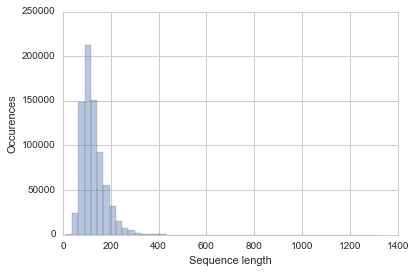

In [8]:
# Concatenate training and validation set for sequence length analysis
# and token id encoding later
X_all = pd.concat([X_train_sample, X_val], axis=0)

# Plot sequence length of questions, and determine outliers
sns.set_style('whitegrid')
seq_length = []
for row in X_all:
    seq_length.append(len(row))

sns.distplot(seq_length, kde=False)
plt.xlabel("Sequence length")
plt.ylabel("Occurences")

print("seq length stats: ")
print("Max: ", max(seq_length))
print("Min: ", min(seq_length))
print("")
Q1 = np.percentile(seq_length, 25)
Q3 = np.percentile(seq_length, 75)
IQR = Q3 - Q1
print("Q1: ", Q1)
print("Mean: ", np.mean(seq_length))
print("Q3: ", Q3)
print("IQR: ", IQR)
print("Outlier range: < " + str(Q1 - 1.5*IQR) + " and > " + str(Q3 + 1.5*IQR))

In [9]:
def build_vocabulary(df):
    '''
    Assigns an id to each unique word in dataset
    '''
    # Splits train dataset into tokens and calculates the unique number of tokens
    unique = [word for row in df for word in row.split()]
    token_count = set(unique)
    print("Vocabulary size: ", len(token_count))
    
    # Build vocabulary
    vocab = {}
    for i, u in enumerate(token_count):
        vocab[u] = i
    
    return vocab

vocab = build_vocabulary(X_all)

('Vocabulary size: ', 107557)


In [10]:
def convert_token_to_token_id(df, vocabulary):
    '''
    Converts tokens in dataframe into ids, referencing from a vocabulary
    '''
    token_id = []
    for row in df:
        iid = []
        for word in row.split():
            iid.append(vocabulary.get(word))
        token_id.append(iid)
    return token_id

X_train_sample = convert_token_to_token_id(X_train_sample, vocab)
X_val = convert_token_to_token_id(X_val, vocab)

print(X_train_sample[:2])
print(X_val[:2])

[[12607, 84925, 43748, 55720, 57468, 45385, 69880, 53246, 9535, 20354, 70708, 28980, 64874, 30452, 106257, 55851, 24785, 4970, 20354, 64586, 70594, 47163, 45385, 83331, 98474, 23190, 1674, 47163, 59088, 54998, 22142, 58526, 70308, 11502, 89714, 81834, 60085, 18367, 14650, 67446, 89645, 10010, 650, 88181, 27057, 1543, 70299, 41552, 47163, 52100, 20362, 27536, 47163, 47810, 45169, 7743, 18367, 34903, 80932, 3252, 64874], [92184, 16549, 7274, 20354, 31939, 64874, 92184, 80932, 7274, 20354, 31939, 52100, 12607, 27710, 96492, 64874]]
[[40419, 70497, 73133, 68785, 63050, 8176, 20354, 78973, 64874, 40419, 70497, 73133, 68785, 63050, 8176, 20354, 53784, 64874], [92184, 106257, 99638, 24785, 70708, 13509, 95438, 56539, 67446, 86274, 35641, 64874, 92184, 106257, 99638, 102619, 95438, 56539, 67446, 12199, 53244, 64874]]


In [11]:
# Saves preprocessed data into a pickle file
import pickle

with open('preprocess_1.pickle', 'wb') as f:
    pickle.dump(X_train_sample, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(X_val, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_train_sample, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_val, f, protocol=pickle.HIGHEST_PROTOCOL)
    
print("File saved.")

File saved.
